In [ ]:
!pip install numpy
!pip install -U scikit-learn scipy matplotlib
!pip install scipy
!pip install pandas
!pip install joblib
!pip install seaborn

: 

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics
from scipy.io import arff

In [2]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

In [5]:
def getProcessedDataFrame(filepath):
  dataset = arff.loadarff(filepath)
  #print(type(dataset))
  df = pd.DataFrame(dataset[0])
  str_df = df.select_dtypes([np.object]) 
  str_df = str_df.stack().str.decode('utf-8').unstack()

  for col in str_df.columns:
    str_df[col] = str_df[col].astype(int)
  return str_df


In [6]:
complete_training = getProcessedDataFrame('dataset/Training Dataset.arff')

/tmp/ipykernel_130800/3434383168.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  str_df = df.select_dtypes([np.object])


In [7]:
complete_training['Result'].value_counts()

Result
 1    6157
-1    4899
Name: count, dtype: int64

In [8]:
reduced_df = complete_training[['having_IP_Address', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Redirect', 'on_mouseover', 'RightClick', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Statistical_report', 'Result']]


In [9]:
def convertEncodingToPositive(dataframe):

  mapping = {-1: 2, 0: 0, 1: 1}

  col_map = {}

  for col in dataframe:
    col_map[col] = mapping

  for i in range(dataframe.shape[0]):
    # if (i%100 == 0):
    #   print(i)
    for j in range(dataframe.shape[1]):
      dataframe.loc[i][j] = mapping[dataframe.loc[i][j]]

convertEncodingToPositive(reduced_df)

#print(reduced_df)

/tmp/ipykernel_130800/2073239758.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[i][j] = mapping[dataframe.loc[i][j]]


In [10]:
from sklearn.model_selection import train_test_split, KFold

X_reduced = reduced_df.iloc[:,0:25]
y_reduced = reduced_df.iloc[:, -1]

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=7, stratify=y_reduced)
print(X_test_red.shape)

(2212, 25)


In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=786)
X_train_red = X_train_red.to_numpy()
X_test_red = X_test_red.to_numpy()
y_train_red = y_train_red.to_numpy()
y_test_red = y_test_red.to_numpy()
for train, test in kf.split(X_train_red):
  print(X_train_red[train].shape, y_train_red[train].shape, X_train_red[test].shape, y_train_red[test].shape)

(7075, 25) (7075,) (1769, 25) (1769,)
(7075, 25) (7075,) (1769, 25) (1769,)
(7075, 25) (7075,) (1769, 25) (1769,)
(7075, 25) (7075,) (1769, 25) (1769,)
(7076, 25) (7076,) (1768, 25) (1768,)


In [12]:
from sklearn.metrics import confusion_matrix
def plot_cm(y_val, y_pred):
  labels = [1, 0]
  cm = confusion_matrix(y_val, y_pred, labels)
  # print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  plt.title('Confusion matrix of the classifier')
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [19]:
import pickle
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
X_train_red_onehot = encoder.fit_transform(X_train_red)
X_test_red_onehot = encoder.transform(X_test_red)
pickle.dump(encoder, open("One_Hot_Encoder", 'wb'), protocol=2)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [18]:
def grid_search_svm(X_train_red_onehot, y_train_red):
  svm_clf = svm.SVC()
  param_grid = {'C': [0.1, 1, 10, 100],  
                'gamma': [1, 0.1, 0.01, 0.001], 
                'kernel': ['rbf', 'linear']}  

  gs_svm = GridSearchCV(svm.SVC(), param_grid, cv = 3)
  gs_results = gs_svm.fit(X_train_red_onehot, y_train_red)

  return gs_results.best_params_

bestparams_svm = grid_search_svm(X_train_red_onehot, y_train_red)
print(bestparams_svm)

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [20]:
def to_use_SVM(X_train_red_onehot, y_train_red):
  accuracy_scores_svm = []
  for train, val in kf.split(X_train_red_onehot):
    svm_clf = svm.SVC(kernel='rbf', gamma = 0.1, C = 10, probability=True)
    svm_clf = svm_clf.fit(X_train_red_onehot[train], y_train_red[train])
    tp, fn, fp, tn = metrics.confusion_matrix(y_train_red[val], svm_clf.predict(X_train_red_onehot[val])).ravel()
    plot_cm(y_train_red[val], svm_clf.predict(X_train_red_onehot[val]))
    
    accuracy = (tn+tp)/(fp+fn+tp+tn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    fpr = fp/(fp+tn)
    f1 = 2*precision*recall/(precision + recall)
    accuracy_scores_svm.append((accuracy, precision, recall, fpr, f1))


  return np.mean(accuracy_scores_svm, axis=0)

metric_svm = to_use_SVM(X_train_red_onehot, y_train_red)
print(metric_svm)

TypeError: confusion_matrix() takes 2 positional arguments but 3 were given

In [17]:
def to_test_SVM(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red):
  svm_clf = svm.SVC(kernel='rbf', gamma = 0.1, C = 10, probability=True)
  svm_clf = svm_clf.fit(X_train_red_onehot, y_train_red)
  tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, svm_clf.predict(X_test_red_onehot)).ravel()
  accuracy = (tn+tp)/(fp+fn+tp+tn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  fpr = fp/(fp+tn)
  f1 = 2*precision*recall/(precision + recall)
  pickle.dump(svm_clf, open("./classifier/SVM_Final_Model", 'wb'))
  return accuracy

test_accuracy = to_test_SVM(X_test_red_onehot, y_test_red, X_train_red_onehot, y_train_red)
print(test_accuracy)

0.9647377938517179


In [18]:
filename_dt = './classifier/SVM_Final_Model'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_train_red, loaded_model.predict(X_train_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print(accuracy)
print(recall)
print(fpr)

0.9799864314789688
0.9809137055837563
0.02117887216126563


In [19]:
filename_dt = './classifier/SVM_Final_Model'
loaded_model = pickle.load(open(filename_dt, 'rb'))
tp, fn, fp, tn = metrics.confusion_matrix(y_test_red, loaded_model.predict(X_test_red_onehot)).ravel()
accuracy = (tn+tp)/(fp+fn+tp+tn)
recall = tp/(tp+fn)
fpr = fp/(fp+tn)
print(accuracy)
print(recall)
print(fpr)

0.9647377938517179
0.9691558441558441
0.04081632653061224


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8844 samples in 0.013s...
[t-SNE] Computed neighbors for 8844 samples in 0.328s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8844
[t-SNE] Computed conditional probabilities for sample 2000 / 8844
[t-SNE] Computed conditional probabilities for sample 3000 / 8844
[t-SNE] Computed conditional probabilities for sample 4000 / 8844
[t-SNE] Computed conditional probabilities for sample 5000 / 8844
[t-SNE] Computed conditional probabilities for sample 6000 / 8844
[t-SNE] Computed conditional probabilities for sample 7000 / 8844
[t-SNE] Computed conditional probabilities for sample 8000 / 8844
[t-SNE] Computed conditional probabilities for sample 8844 / 8844
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.486942
[t-SNE] KL divergence after 1000 iterations: 0.230770


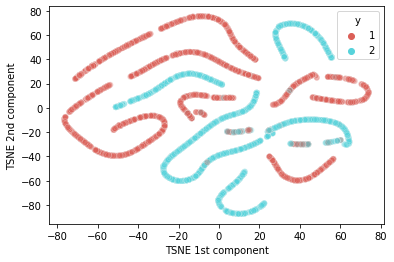

In [20]:
from sklearn.manifold import TSNE

def tsne_analysis():
  """ For TSNE analysis on the training dataset with 
  last hidden layer output"""

  filename_dt = './classifier/SVM_Final_Model'
  loaded_model = pickle.load(open(filename_dt, 'rb'))
  
  hidden_opt = loaded_model.predict_proba(X_train_red_onehot)
  df = pd.DataFrame(hidden_opt)
  df['y'] = y_train_red
  df['label'] = df['y'].apply(lambda i: str(i))
  tsne = TSNE(n_components = 2, perplexity = 50, verbose = 1, n_iter = 1000)
  tsne_res = tsne.fit_transform(hidden_opt)

  df['TSNE 1st component'] = tsne_res[:,0]
  df['TSNE 2nd component'] = tsne_res[:,1]

  sns.scatterplot(
    x = "TSNE 1st component", y = "TSNE 2nd component",
    hue = 'y',
    palette = sns.color_palette("hls", 2),
    data = df,
    legend = "full",
    alpha = 0.3
  )
  plt.show()

tsne_analysis()